# Detecting Weapon Objects by using one-stage object detection model


I have used Object Detection API and retrain [RetinaNet](https://arxiv.org/abs/1708.02002) model to spot weapon objects using just 4 training images.

RetinaNet is one of the best one-stage object detection models that has proven to work well with dense and small scale objects. For this reason, it has become a popular object detection model that we use with aerial and satellite imagery.

 

The model was introduced by Facebook AI Research to tackle the dense detection problem. It was needed to fill in for the imbalances and inconsistencies of the single-shot object detectors like YOLO and SSD while dealing with extreme foreground-background classes.

 
In essence, originial RetinaNet is a composite network composed of:

* Backbone Network (i.e. Bottom-up pathway + Top down a pathway with lateral 
connections eg. ResNet + FPN)

* Subnetwork for object Classification

* Subnetwork for object Regression

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/08/image13-850x217.png' alt='model'>

First of all, we need to clone the Tensorflow Model Garden and install the Tensorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

In [1]:
!rm -rf ./models/

!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 2476, done.
remote: Counting objects: 100% (2476/2476), done.
remote: Compressing objects: 100% (2040/2040), done.
remote: Total 2476 (delta 617), reused 1340 (delta 407), pack-reused 0
Receiving objects: 100% (2476/2476), 30.86 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (617/617), done.


Install the Object Detection API

In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
     |████████████████████████████████| 9.0MB 7.3MB/s 
     |████████████████████████████████| 358kB 45.0MB/s 
     |████████████████████████████████| 1.1MB 45.3MB/s 
     |████████████████████████████████| 153kB 23.1MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 829kB 43.0MB/s 
     |████████████████████████████████| 17.7MB 240kB/s 
     |████████████████████████████████| 2.2MB 49.1MB/s 
     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 37.6MB 122kB/s 
     |████████████████████████████████| 1.2MB 28.4MB/s 
     |████████████████████████████████| 645kB 25.5MB/s 
     |████████████████████████████████| 706kB 23.4MB/s 
     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 174kB 39.6MB/s 
     |████████████████████████████████| 112kB 24.8MB/s 
  Created wheel for 

## Import packages

Let's now import the libraries that we will need for this project 

In [5]:
import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import zipfile
import io
import scipy.misc
import numpy as np
import tensorflow as tf

# Import Object Detection API packages

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils  import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

print('Done')

Done


## Utilites


In [6]:
def load_image_into_numpy_array(path):
    
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

## Visualize the Gun images data

We will use 4 images of guns that using for training.

./training/gun_1.jpg
./training/gun_2.jpg
./training/gun_3.jpg
./training/gun_4.jpg


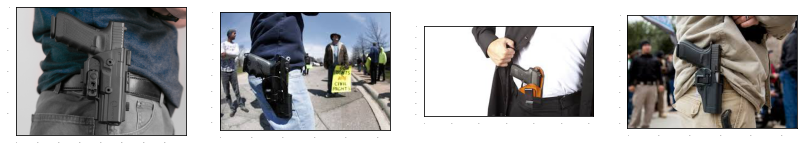

In [8]:
%matplotlib inline
train_image_dir = './training'
train_images_np = []

for i in range(1, 5):

    # define the path (string) for each image
    image_path = os.path.join('./training/gun_'+str(i)+'.jpg')
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 4, idx+1)
    plt.imshow(train_image_np)

plt.show()

## Preparing data for training

I will create ground truth boxes. So, I am drawing my own ground truth boxes. For this, I will use **colab_utils.annotate** 

In [10]:
# Define the list of ground truth boxes
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

## Define the category index dictionary

We need to tell the model which integer class ID to assign to the 'has gun' category, and what 'name' to associate with that integer id.

In [11]:
has_gun_class_id = 1

category_index = {has_gun_class_id : 
{'id'  : has_gun_class_id, 
 'name': 'has gun'}
}

num_classes = 1

print(category_index[has_gun_class_id])

{'id': 1, 'name': 'has gun'}


We will now do some data preprocessing so it is formatted properly before it is fed to the model:

* Convert the class labels to one-hot representations
* Convert everything (i.e. train images, gt boxes and class labels) to tensors.

In [14]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor( train_image_np, dtype=tf.float32), axis=0))
    
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
  gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

print('Done')

Done


## Download the checkpoints with the pre-trained weights

Next, we will download [RetinaNet](https://arxiv.org/abs/1708.02002) and copy it inside the object detection directory. Let's download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.Then, untar (decompress) the tar file and move the decompressed checkpoint to models/research/object_detection/test_data/


In [15]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-03-28 08:59:46--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   104MB/s    in 2.3s    

2021-03-28 08:59:48 (104 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



## Configure the model


#### pipeline_config
- In the Colab, on the left side table of contents, click on the folder icon to display the file browser for the current workspace.  
- Navigate to `models/research/object_detection/configs/tf2`.  The folder has multiple .config files.  
- Look for the file corresponding to ssd resnet 50 version 1 640x640.
- You can double-click the config file to view its contents. This may help you as you complete the next few code cells to configure your model.
- Set the `pipeline_config` to a string that contains the full path to the resnet config file, in other words: `models/research/.../... .config`


#### configs
If you look at the module [config_util](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/config_util.py) that you imported, it contains the following function:

```
def get_configs_from_pipeline_file(pipeline_config_path, config_override=None):
```
- Please use this function to load the configuration from your `pipeline_config`.
  - `configs` will now contain a dictionary.


In [18]:
tf.keras.backend.clear_session()

pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']

# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

model_config.ssd.freeze_batchnorm = True
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

## Build the custom model

We will use model_builder which has a function *build*

In [19]:
detection_model = model_builder.build(
    model_config, is_training= True
)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


## Restore weights from my checkpoint

Now, I will selectively restore weights from my checkpoint.
- My end goal is to create a custom model which reuses parts of, but not all of the layers of RetinaNet (currently stored in the variable `detection_model`.)
  - The parts of RetinaNet that I want to reuse are:
    - Feature extraction layers
    - Bounding box regression prediction layer
  - The part of RetinaNet that I will not want to reuse is the classification prediction layer (since I will define and train my own classification layer specific to guns).
  - For the parts of RetinaNet that I want to reuse, I will also restore the weights from the checkpoint that you selected.

In [21]:
detection_model._box_predictor

# View variables in _box_predictor
vars(detection_model._box_predictor)

{'_activity_regularizer': None,
 '_additional_projection_layers': ListWrapper([]),
 '_apply_batch_norm': True,
 '_auto_track_sub_layers': True,
 '_autocast': True,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f3443a48410>,
 '_build_input_shape': None,
 '_callable_losses': [],
 '_compute_dtype_object': tf.float32,
 '_conv_hyperparams': <object_detection.builders.hyperparams_builder.KerasLayerHyperparams at 0x7f3443a52910>,
 '_default_training_arg': None,
 '_depth': 256,
 '_dtype_policy': <Policy "float32">,
 '_dynamic': False,
 '_expects_mask_arg': True,
 '_expects_training_arg': True,
 '_freeze_batchnorm': True,
 '_head_scope_conv_layers': DictWrapper({}),
 '_inbound_nodes_value': [],
 '_initial_weights': None,
 '_inplace_batchnorm_update': False,
 '_input_spec': None,
 '_instrumented

## Define Checkpoints for the box predictor

We will define box_predictor_checkpoint to be checkpoint for these two layers of the detection_model's box predictor

In [23]:
tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

#Define the temporary model checkpoint
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)

## Restoring the checkpoint
First, find and set the `checkpoint_path`

- checkpoint_path: 
  - If you completed the previous code cell that downloads and moves the checkpoint, you'll see a subfolder named "checkpoint".  
    - The 'checkpoint' folder contains three files:
      - checkpoint
      - ckpt-0.data-00000-of-00001
      - ckpt-0.index
    - Please set checkpoint_path to the path to the full path `models/.../ckpt-0` 
      - Notice that you don't want to include a file extension after `ckpt-0`.
    - **IMPORTANT**: Please don't set the path to include the `.index` extension in the checkpoint file name.  
      - If you do set it to `ckpt-0.index`, there won't be any immediate error message, but later during training, you'll notice that your model's loss doesn't improve, which means that the pre-trained weights were not restored properly.

Next, define one last checkpoint using `tf.train.Checkpoint()`.
- For the single keyword argument, 
  - Set the key as `model=` 
  - Set the value to your temporary model checkpoint that you just defined.
- **IMPORTANT**: You'll need to set the keyword argument as `model=` and not something else like `detection_model=`.
- If you set this keyword argument to anything else, it won't show an immmediate error, but when you train your model on the zombie images, your model loss will not decrease (your model will not learn).

Finally, call this checkpoint's `.restore()` function, passing in the path to the checkpoint.

In [24]:
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

checkpoint =tf.train.Checkpoint(model = detection_model) 

# Restore the checkpoint to the checkpoint path
tmp_model_checkpoint.restore(checkpoint_path).expect_partial()

## Running a dummy image to generate the model variables

Run a dummy image through the model so that variables are created. We need to select the trainable variables later in Exercise 9 and right now, it is still empty. Try running `len(detection_model.trainable_variables)` in a code cell and you will get `0`. We will pass in a dummy image through the forward pass to create these variables.

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459): 
    - takes in a tensor representing an image and returns
    - returns `image, shapes`
    - For the dummy image, you can declare a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]). 
    - Remember that your images have dimensions 640 x 640 x 3. 
    - You can pass in a batch of 1 when making the dummy image. 

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").
   

In [25]:
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

print('Weights restored!')

Weights restored!


In [26]:
#Set training hyperparameters
tf.keras.backend.set_learning_phase(True)
batch_size = 4

num_batches = 100

learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate= learning_rate, momentum= 0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [27]:
# define a list that contains the layers that  wish to fine tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

## Train model
We'll define a function that handles training for one batch, which we'll later use in your training loop.

First, walk through these code cells to learn how we'll perform training using this model.

In [28]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


We can pre-process each image and save their outputs into two separate lists

* One list of the preprocessed images
* One list of the true shape for each preprocessed image

In [29]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

## Make a prediction
The `detection_model` also has a `.predict` function.  According to the source code for [predict](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)


In [30]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [31]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

Now we can calculate the loss

In [32]:
# Calculate the loss after you've provided the ground truth 
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.57324779
classification loss 1.11172652


## Defining one training step

In [33]:

# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
        # Preprocess the images
        
        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0) 
        true_shape_tensor = preprocessed_image_tensor.shape 

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
    return total_loss

## Run the training loop

Run the training loop using the training step function that we just defined.

In [34]:
print('Start', flush=True)

for idx in range(num_batches):
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done')

Start
batch 0 of 100, loss=1.5296891
batch 10 of 100, loss=0.4121471
batch 20 of 100, loss=0.1213492
batch 30 of 100, loss=0.061843917
batch 40 of 100, loss=0.034526005
batch 50 of 100, loss=0.025534539
batch 60 of 100, loss=0.021115808
batch 70 of 100, loss=0.018568816
batch 80 of 100, loss=0.016889358
batch 90 of 100, loss=0.015600436
Done


## Load test images and run inference with new model

You we now test your model on a new set of images which are stored in a result/ directory. The cell below loads these images into numpy arrays to prepare it for inference

In [35]:
test_image_dir = './result/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 2):
    image_path = os.path.join(test_image_dir, 'test' + "{0:04}".format(i) + '.jpeg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./result/test0000.jpeg
./result/test0001.jpeg


In [36]:
#  Preprocess, predict, and post process an image

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):

    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

In [40]:
label_id_offset = 1
results1 = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./result/gif_frame_" + ('%04d' % i) + ".jpg")
    results1['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results1['scores'].append(detections['detection_scores'][0][0].numpy())

We can also check if the model detects a gun class in the images by examining the scores key of the results dictionary.

In [41]:
x = np.array(results1['scores'])

# percent of frames where a gun is detected
gun_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(gun_detected)

1.0


We can also display some still frames and inspect visually. 

Frame 0


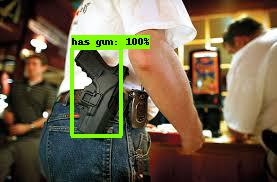

In [43]:
print('Frame 0')
display(IPyImage('./result/gif_frame_0001.jpg'))
print()

Frame 1


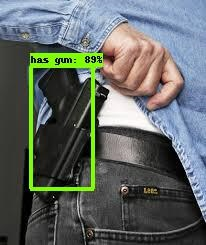

In [44]:
print('Frame 1')
display(IPyImage('./result/gif_frame_0000.jpg'))
print()

In [47]:
#Save results
import pickle

with open('results.data', 'wb') as filehandle:
    pickle.dump(results1['boxes'], filehandle)

#from google.colab import files
#files.download('results.data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### References:

[Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)


[TensorFlow blog](https://blog.tensorflow.org/)

[TensorFlow Object Detection API](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html)
 
[TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)


[Advanced Computer Vision with TensorFlow](https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow?specialization=tensorflow-advanced-techniques)

[Intro to Object Detection with TensorFlow](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_tf2_colab.ipynb)
 
[Eager Few Shot Object Detection Colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb)
